##**PANAROMA APPLICATION HELPS IN STITCHING IMAGES TOGETHER** ##
by : 
- SUVANSH ARORA[20MCS018].
- SHIVAM SHRIVASTAVA[20MCS015].


**1.IMPORTING ALL THE REQUIRED LIBRARIES :**

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import imageio
import imutils #grabs contours
# cv2.ocl.setUseOpenCL(False)

* Sift and surf cannot be used with new versions of open-cv that is why using **orb local invariant descriptor.**

**FAST**

* 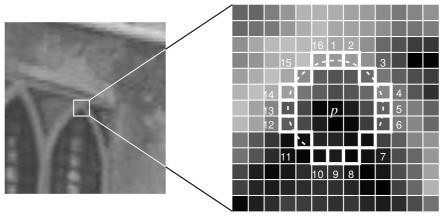
* (lighter than p, darker than p or similar to p). 
* If more than 8 pixels are darker or brighter than p than it is selected as a keypoint. 

**BRIEF**
* In brief, each keypoint is described by a feature vector which is 128–512 bits string.
* 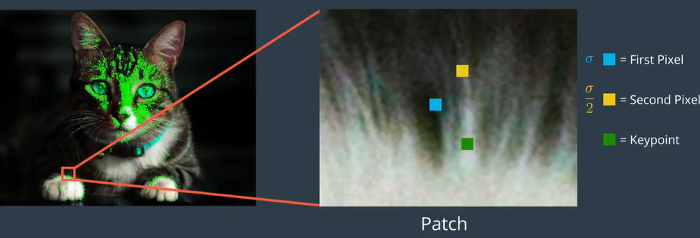
* BRIEF is not rotation invariant , so ORB uses rotation aware brief.

In [ ]:
# orb is based on = FAST keypoint detector and the BRIEF descriptor
feature_extractor = 'orb' 
feature_matching = 'bf'
#bf = brute - force.
#knn = this can also be used for feature matching.

**2.READ IMAGES AND TRANSFROM THEM TO GRAYSCALE.**
* Opencv defines the color channel in the order BGR.Transform it to RGB to be compatible to matplotlib

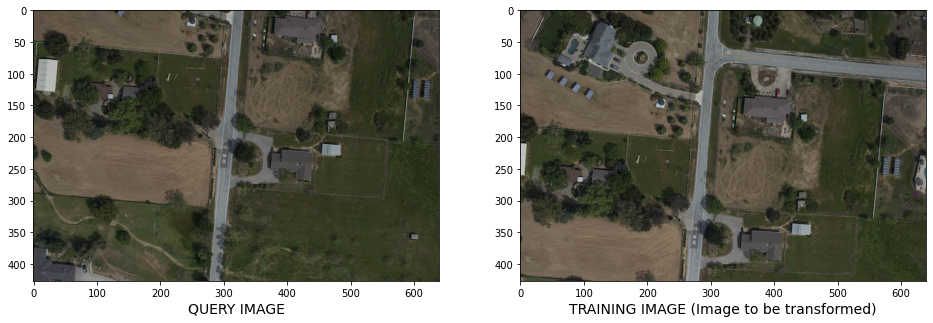

In [ ]:
#trainImg = image to be transformed.
#queryImg = image with reference to which tranformation takes place.
trainImg = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto3A.jpg')
trainImg_gray = cv2.cvtColor(trainImg, cv2.COLOR_RGB2GRAY)
queryImg = imageio.imread('http://www.ic.unicamp.br/~helio/imagens_registro/foto3B.jpg')
queryImg_gray = cv2.cvtColor(queryImg, cv2.COLOR_RGB2GRAY)
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, constrained_layout=False, figsize=(16,9))
ax1.imshow(queryImg, cmap="gray")
ax1.set_xlabel("QUERY IMAGE", fontsize=14)

ax2.imshow(trainImg, cmap="gray")
ax2.set_xlabel("TRAINING IMAGE (Image to be transformed)", fontsize=14)

plt.show()

**3.FUNCTION THAT DETECTS AND DESCRIBES THE FEATURE DESCRIPTORS.**

In [ ]:
def detectAndDescribe(image, method=None):
    if method == 'sift':
        descriptor = cv2.xfeatures2d.SIFT_create()
    elif method == 'surf':
        descriptor = cv2.xfeatures2d.SURF_create()
    elif method == 'orb':
        descriptor = cv2.ORB_create()
        
    # KPS= keypoints .
    (kps, features) = descriptor.detectAndCompute(image, None)
    
    return (kps, features)

In [ ]:
kpsA, featuresA = detectAndDescribe(trainImg_gray, method=feature_extractor)
kpsB, featuresB = detectAndDescribe(queryImg_gray, method=feature_extractor)

**4.DISPLAYING KEYPOINTS EXTRACTED FROM THE FUNCTION CALL OF PREVIOUS STEP.**

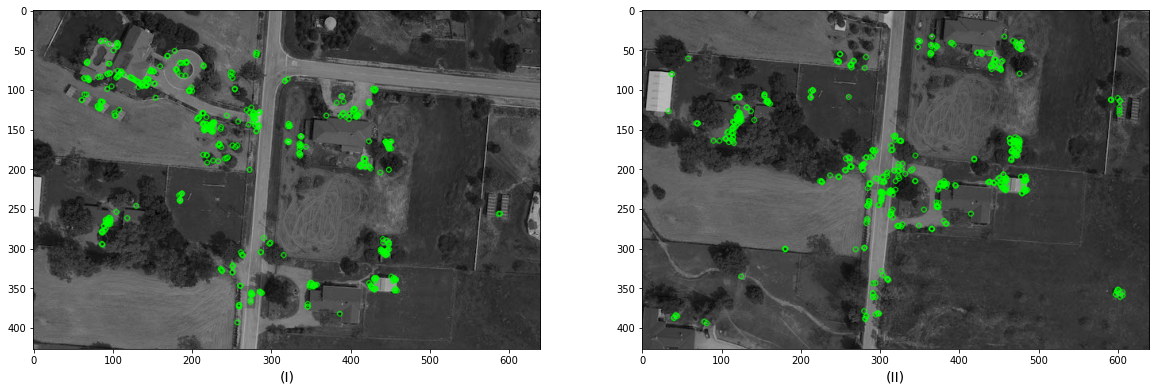

In [ ]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(20,8), constrained_layout=False)
ax1.imshow(cv2.drawKeypoints(trainImg_gray,kpsA,None,color=(0,255,0)))
ax1.set_xlabel("(I)", fontsize=14)
ax2.imshow(cv2.drawKeypoints(queryImg_gray,kpsB,None,color=(0,255,0)))
ax2.set_xlabel("(II)", fontsize=14)

plt.show()

**5.Create and return a Matcher Object**

In [ ]:
def createMatcher(method,crossCheck):
    if method == 'sift' or method == 'surf':
        bf = cv2.BFMatcher(cv2.NORM_L2, crossCheck=crossCheck)
    elif method == 'orb':
        bf = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=crossCheck)
    return bf

**6.MATCHES DESCIPTORS.**

In [ ]:
def matchKeyPointsBF(featuresA, featuresB, method):
    bf = createMatcher(method, crossCheck=True)
    best_matches = bf.match(featuresA,featuresB)
    # Sort the features in order of distance.
    # The points with small distance (more similarity) are ordered first in the vector
    rawMatches = sorted(best_matches, key = lambda x:x.distance)
    print("Raw matches (Brute force):", len(rawMatches))
    return rawMatches

**7.compute the raw matches and initialize the list of actual matches**

In [ ]:
def matchKeyPointsKNN(featuresA, featuresB, ratio, method):
    bf = createMatcher(method, crossCheck=False)
    
    rawMatches = bf.knnMatch(featuresA, featuresB, 2)
    print("Raw matches (knn):", len(rawMatches))
    matches = []

    # loop over the raw matches
    for m,n in rawMatches:
        # ensure the distance is within a certain ratio of each
        # other (i.e. Lowe's ratio test)
        if m.distance < n.distance * ratio:
            matches.append(m)
    return matches

Raw matches (Brute force): 204


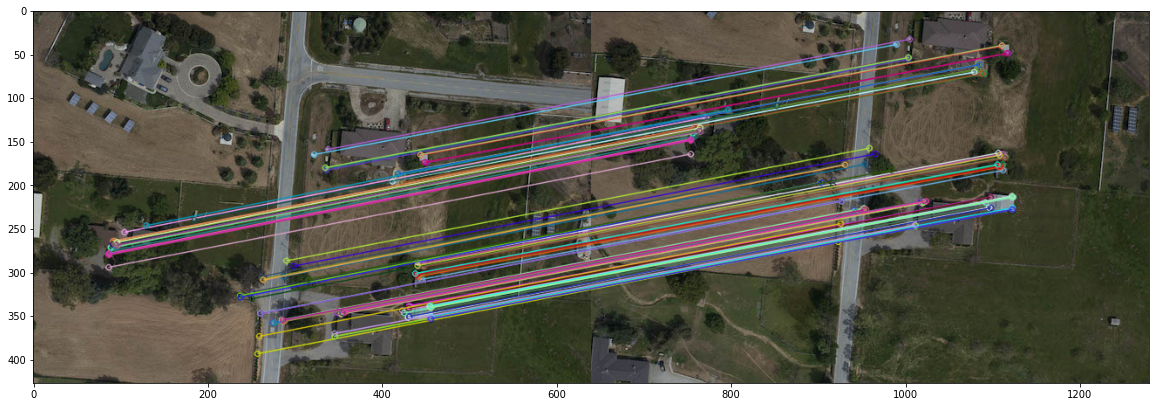

In [ ]:

fig = plt.figure(figsize=(20,8))

if feature_matching == 'bf':
    matches = matchKeyPointsBF(featuresA, featuresB, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,matches[:100],
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
elif feature_matching == 'knn':
    matches = matchKeyPointsKNN(featuresA, featuresB, ratio=0.75, method=feature_extractor)
    img3 = cv2.drawMatches(trainImg,kpsA,queryImg,kpsB,np.random.choice(matches,100),
                           None,flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    

plt.imshow(img3)
plt.show()

**8.HOMOGRAPHY MATRIX COMPUTATION.**

In [ ]:
def getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh):
    # convert the keypoints to numpy arrays
    kpsA = np.float32([kp.pt for kp in kpsA])
    kpsB = np.float32([kp.pt for kp in kpsB])
    
    if len(matches) > 4:

        # construct the two sets of points
        ptsA = np.float32([kpsA[m.queryIdx] for m in matches])
        ptsB = np.float32([kpsB[m.trainIdx] for m in matches])
        
        # estimate the homography between the sets of points
        (H, status) = cv2.findHomography(ptsA, ptsB, cv2.RANSAC,
            reprojThresh)

        return (matches, H, status)
    else:
        return None

In [ ]:
M = getHomography(kpsA, kpsB, featuresA, featuresB, matches, reprojThresh=4)
if M is None:
    print("Error!")
(matches, H, status) = M
print(H)

[[ 9.93000564e-01 -1.66185702e-02  3.16258570e+01]
 [ 1.74198468e-02  9.87264313e-01 -1.30286376e+02]
 [ 6.06004237e-06 -3.15634426e-05  1.00000000e+00]]


**9.PANAROMA CORRECTION**

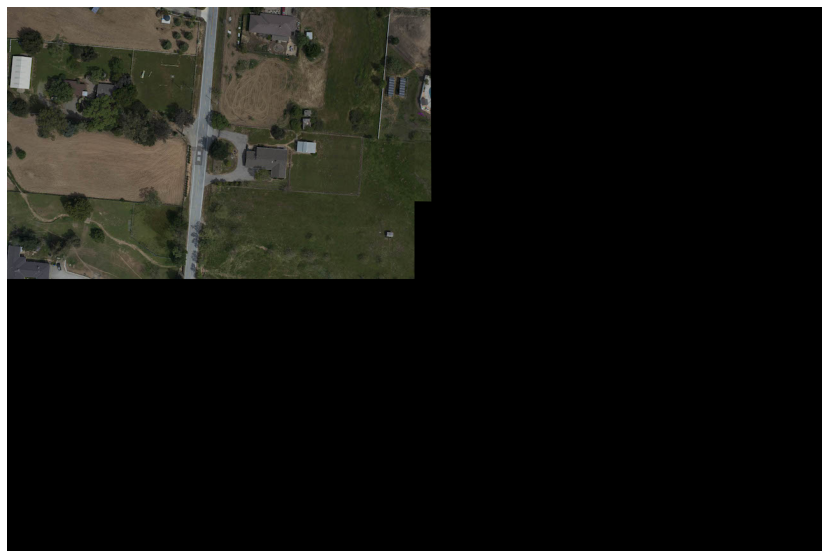

In [ ]:

width = trainImg.shape[1] + queryImg.shape[1]
height = trainImg.shape[0] + queryImg.shape[0]

result = cv2.warpPerspective(trainImg, H, (width, height))
result[0:queryImg.shape[0], 0:queryImg.shape[1]] = queryImg

plt.figure(figsize=(20,10))
plt.imshow(result)

plt.axis('off')
plt.show()

**10.transform the panorama image to grayscale and threshold it**

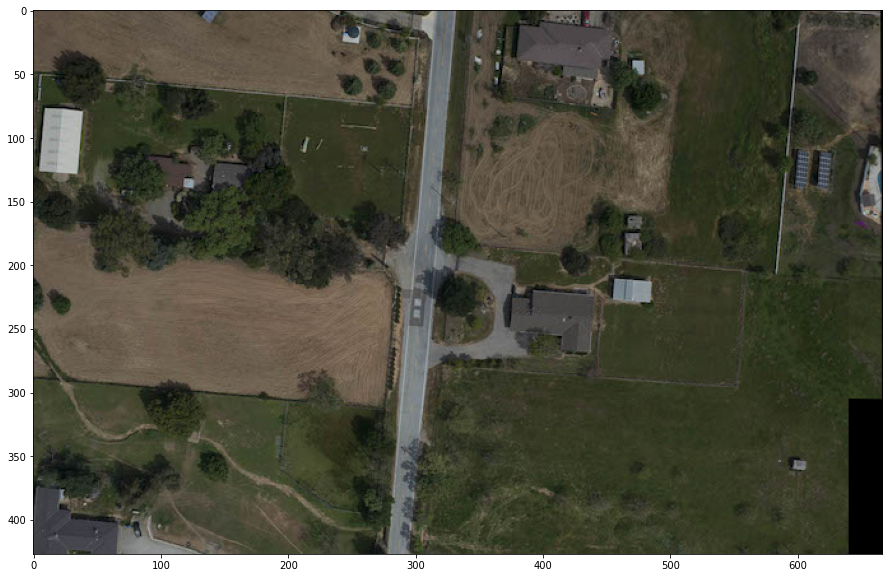

In [ ]:
gray = cv2.cvtColor(result, cv2.COLOR_BGR2GRAY)
thresh = cv2.threshold(gray, 0, 255, cv2.THRESH_BINARY)[1]

# Finds contours from the binary image
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

# get the maximum contour area
c = max(cnts, key=cv2.contourArea)

# get a bbox from the contour area
(x, y, w, h) = cv2.boundingRect(c)

# crop the image to the bbox coordinates
result = result[y:y + h, x:x + w]

# show the cropped image
plt.figure(figsize=(20,10))
plt.imshow(result)

**THANK YOU**